In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
from shutil import copyfile
import cv2 as cv
from google.colab.patches import cv2_imshow
from cv2 import CascadeClassifier
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2
from sklearn.neighbors import KDTree
import joblib

## Load dataset 

VIPs dataset

In [2]:
# Link Google Drive account, transfer dataset, and extract files
from google.colab import drive
drive.mount('/content/gdrive')

copyfile('gdrive/My Drive/vip.zip', 'vip.zip')
zip = zipfile.ZipFile('vip.zip')
zip.extractall()
zip.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data loader + face detection

In [3]:
def face_detection(img):
    # funzione che data un'immagine ritorna solamente il crop della faccia che trova al suo interno
    classifier = CascadeClassifier('/haarcascade_frontalface_default.xml')
    box = classifier.detectMultiScale(img, minNeighbors=20)
    #se non trova nessuna faccia non ritorna niente
    (x,y,w,h) = (0,0,0,0)
    if box is ():
        return None
    #altrimenti ritorna solo la prima faccia
    else:
        (x,y,w,h) = box[0]
        return cv.resize(img[y:y+h, x:x+w, :], (224,224))

In [4]:
def load_data():
    # funzione che per con le immagini crea il dataset di train e test applicando prima la funzione di face detection
    root = '/content/thumbnails_features_deduped_publish'

    paths = []
    images = []

    for folder in sorted(os.listdir(root)):
    #dalla cartella principale apro solo le cartelle (no file .txt etc.)
        if not os.path.isfile(root + "/" + folder):
            print(folder)
            img_count=0
            for iteration,file in enumerate(sorted(os.listdir(root + "/" + folder))):
                # per ogni foto che trovo nelle cartelle vips, opero face detection e salvo il risultato
                # limitando il numero delle foto per persona a 20 (limiti di ram)
                if file.endswith('.jpg') and img_count < 20:
                    img = cv.imread(root + "/" + folder + "/" + file)
                    img = (face_detection(img))
                    #se il face detector trova un'immagine allora la aggiunge al dataset
                    if img is not None:
                        img_count+=1
                        images.append(neural_features(img))
                        # lable
                        paths.append(root + "/" + folder + "/" + file)
    return images, paths

In [5]:
def neural_features(img):
    x = kimage.img_to_array(img)
    x = keras.applications.mobilenet_v2.preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    f = net.predict(x)
    return f.flatten()

Import network fo feature extraction

In [7]:
net = keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='max')

9420800/9406464 [==============================] - 0s 0us/step


In [8]:
X_train, paths = load_data()

50 cent
aamir khan
aaron carter
aaron eckhart
abhishek bachchan
abigail breslin
abraham lincoln
adam ant
adam brody
adam sandler
adolf hitler
adrian grenier
adrian mutu
adriana lima
adriana sklenarikova
adrianne curry
adrien brody
adrienne bailon
agatha christie
agnolo bronzino
agyness deyn
aishwarya rai
akshay kumar
al capone
al franken
al gore
al green
al jarreau
al pacino
alain delon
alan greenspan
alan rickman
alanis morissette
albert einstein
alberto gonzales
alec baldwin
aleister crowley
alejandro sanz
alessandra ambrosio
alex ferguson
alex rodriguez
alexandra kosteniuk
alexandra neldel
alexandre pato
alexis bledel
alfred hitchcock
ali landry
ali larter
alice cooper
alicia keys
alicia silverstone
alicia witt
alina vacariu
alison carroll
alison krauss
alison lohman
alistair darling
allen iverson
allison mack
alyson hannigan
alyssa milano
amanda beard
amanda bynes
amanda peet
amanda tapping
amber heard
amber tamblyn
america ferrera
amisha patel
amitabh bachchan
amr diab
amrita aror

# Build KD-Tree

In [9]:
tree = KDTree(X_train)

Image to query

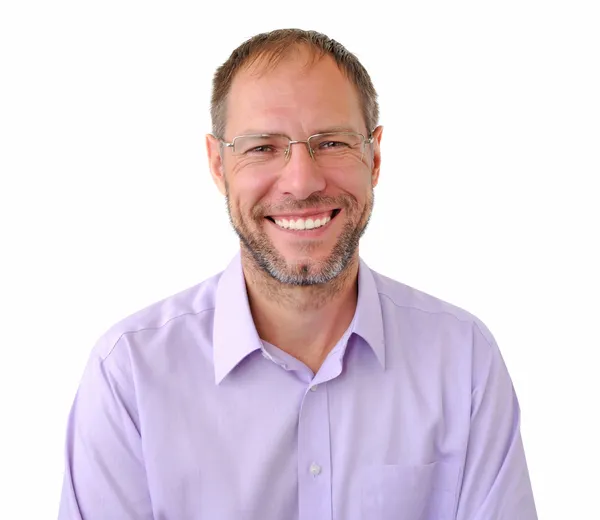

In [10]:
import requests

url = r'https://st.depositphotos.com/1269204/1219/i/600/depositphotos_12196477-stock-photo-smiling-men-isolated-on-the.jpg'
resp = requests.get(url, stream=True).raw
image = np.asarray(bytearray(resp.read()), dtype="uint8")
query_image = cv.imdecode(image, cv.IMREAD_COLOR)

cv2_imshow(query_image)

Preprocessing query

In [11]:
query_image = face_detection(query_image)
query_features = kimage.img_to_array(query_image)
query_features = keras.applications.mobilenet_v2.preprocess_input(query_features)
query_features = np.expand_dims(query_features, axis=0)
query_features = (net.predict(query_features)).flatten()
query_features = np.expand_dims(query_features, axis=0)

## Ricerca query_image nel KDTree e mostra i (num_simil) risultati più simili

In [12]:
_, ind = tree.query(query_features, k=10)

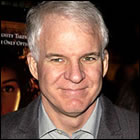

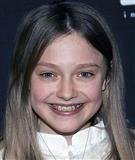

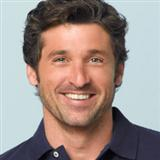

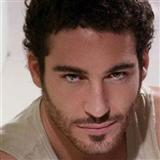

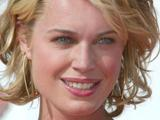

In [13]:
num_simil = 5
for i in range(0,5):
    img = cv.imread(paths[ind[0][i]])
    cv2_imshow(img)

## Salvataggio del KDTree

In [14]:
# Saving the search tree
joblib.dump(tree, 'kdtree.joblib')

['kdtree.joblib']

## Caricamento kdtree

In [15]:
tree = joblib.load('kdtree.joblib')